# **Cifar10 데이터 분류 실습** 💻

## 데이터 준비

Cifar10 데이터를 이용한 분류 실습을 위해 Keras 내부에 저장되어 있는 데이터를 가져옵니다. 




---
__Cifar10 code(참고용)__ 
[link](https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/keras/_impl/keras/datasets/cifar10.py)

```
@tf_export('keras.datasets.cifar10.load_data')
def load_data():
  """Loads CIFAR10 dataset.
  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
  """
  dirname = 'cifar-10-batches-py'
  origin = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
  path = get_file(dirname, origin=origin, untar=True)

  num_train_samples = 50000

  x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
  y_train = np.empty((num_train_samples,), dtype='uint8')

  for i in range(1, 6):
    fpath = os.path.join(path, 'data_batch_' + str(i))
    (x_train[(i - 1) * 10000:i * 10000, :, :, :],
     y_train[(i - 1) * 10000:i * 10000]) = load_batch(fpath)

  fpath = os.path.join(path, 'test_batch')
  x_test, y_test = load_batch(fpath)

  y_train = np.reshape(y_train, (len(y_train), 1))
  y_test = np.reshape(y_test, (len(y_test), 1))

  if K.image_data_format() == 'channels_last':
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

  return (x_train, y_train), (x_test, y_test)
```




해당 이미지는 32X32 크기로, 총 1,024개의 원소를 갖는 2차원 배열입니다. 

따라서 이미지의 개수에 따라서 아래와 같은 3차원 배열로 표현됩니다. 

`(개수, 32, 32)` 


해당 실습에서는 50,000개의 train set과 10,000개의 test set이 있기 때문에 아래 cell의 출력과 같이 표현됩니다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

170498071/170498071 [==============================] - 16s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


## 데이터 확인

10개의 클래스 안에 아래와 같은 이미지가 있는 것을 확인할 수 있습니다.

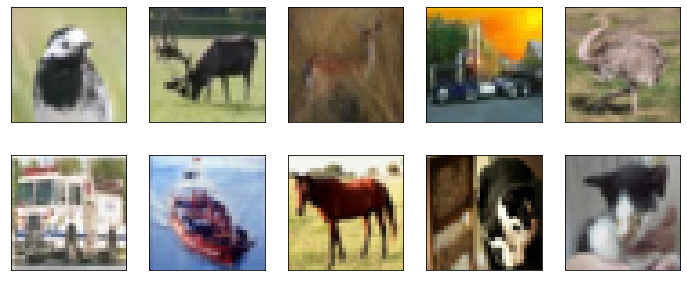

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

samples = np.random.randint(len(X_train), size=10)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(samples):
  plt.subplot(2, 5, i+1, xticks=[], yticks=[])
  plt.imshow(X_train[idx])
plt.show()

## 데이터 정규화

X_train 데이터셋에서 첫 번째 이미지 데이터를 출력했을 때 아래와 같은 결과가 나옵니다. 





```

print(X_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...
```

32X32 배열로 원소들이 저장되어 있고, 각 원소는 0~255 사이의 값을 갖고 있습니다. 이는 각 원소가 데이터의 기본단위인 Byte(8 bit)로 표현 되었기 때문입니다. 


`astype` 함수를 통해 실수화를 하여 255로 나눕니다. 
이를 통해 0~1 사이의 실수로 값을 변환합니다. 


In [4]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## 검증용 데이터 분리

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(35000, 32, 32, 3) (35000,)
(15000, 32, 32, 3) (15000,)
(10000, 32, 32, 3) (10000, 1)


## 레이블 데이터 shape 변경

`reshape` 함수에 -1을 인자값으로 주어 1차원 행렬로 reshape 해줍니다. 

In [9]:
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(35000,)
(15000,)
(10000,)


## 원핫 인코딩

원핫 인코딩을 통해 모든 문자열 값을 숫자로 인코딩합니다. 보편적으로 데이터에 레이블 값을 줄 때 사용합니다.

In [15]:
import tensorflow as tf

y_train_oh = tf.one_hot(y_train, depth=10)
y_val_oh = tf.one_hot(y_val, depth=10)
y_test_oh = tf.one_hot(y_test, depth=10)

print(y_train_oh.shape)

y_train_oh[:5]


(35000, 10)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

## 넘파이  배열로 변환

`y_train_oh`의 타입을 출력해보면 아래와 같은 값이 나옵니다. 

`tensorflow.python.framework.ops.EagerTensor`

현재 y_train_oh의 데이터 타입은 tensor 형태인 것을 확인 할 수 있습니다. 

Tensor 보다 Numpy가 Image array나 데이터 연산등을 다루기 더 쉽기 때문에(시각화 연계, 데이터 가공 부분 등에서) Numpy 형태로 변환해줍니다.


In [16]:
# 넘파이  배열로 변환

y_train_oh = y_train_oh.numpy()
y_val_oh = y_val_oh.numpy()
y_test_oh = y_test_oh.numpy()

print(y_train_oh.shape)
print(y_val_oh.shape)
print(y_test_oh.shape)

(35000, 10)
(15000, 10)
(10000, 10)


## 모델 정의

In [18]:
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential()
  
  model.add(layers.Conv2D(32, 3, padding = 'same', activation='relu', input_shape = (32, 32, 3)))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(64, 3, padding = 'same', activation='relu'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(256, 3, padding = 'same', activation='relu'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(256, 3, padding = 'same', activation='relu'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0

## 모델 학습

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['acc'])

EPOCHS = 100
#EPOCHS = 50
BATCH_SIZE = 256
history = model.fit(X_train, y_train_oh, 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    validation_data = (X_val, y_val_oh))

Epoch 1/100
137/137 [==============================] - 12s 25ms/step - loss: 2.1671 - acc: 0.1856 - val_loss: 2.0867 - val_acc: 0.2324
Epoch 2/100
137/137 [==============================] - 3s 18ms/step - loss: 1.9569 - acc: 0.2857 - val_loss: 1.9244 - val_acc: 0.2965
Epoch 3/100
137/137 [==============================] - 3s 18ms/step - loss: 1.8016 - acc: 0.3450 - val_loss: 1.8173 - val_acc: 0.3404
Epoch 4/100
137/137 [==============================] - 3s 18ms/step - loss: 1.7220 - acc: 0.3746 - val_loss: 1.7508 - val_acc: 0.3656
Epoch 5/100
137/137 [==============================] - 3s 19ms/step - loss: 1.6610 - acc: 0.3949 - val_loss: 1.6677 - val_acc: 0.4024
Epoch 6/100
137/137 [==============================] - 3s 18ms/step - loss: 1.6081 - acc: 0.4140 - val_loss: 1.6244 - val_acc: 0.4139
Epoch 7/100
137/137 [==============================] - 3s 20ms/step - loss: 1.5623 - acc: 0.4320 - val_loss: 1.5598 - val_acc: 0.4393
Epoch 8/100
137/137 [==============================] - 3s 18m

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(16,8))
  
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'],hist['val_loss'],label='val_loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'],hist['acc'], label="Train Accuracy")
  plt.plot(hist['epoch'],hist['val_acc'],label='Val Accuracy')
  plt.legend()

  plt.show()

## 학습 곡선

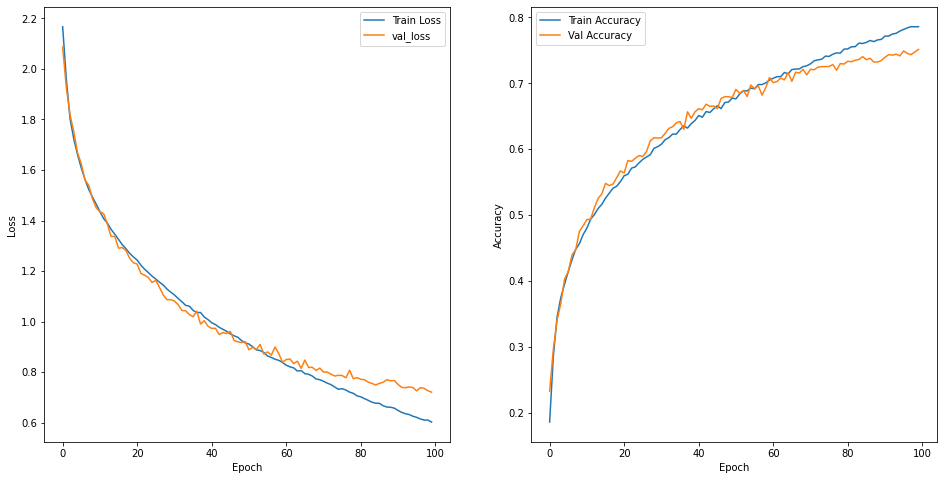

In [ ]:
plot_history(history)

## 예측

In [ ]:

y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)


313/313 [==============================] - 1s 2ms/step


## 모델 평가

혼동행렬 시각화

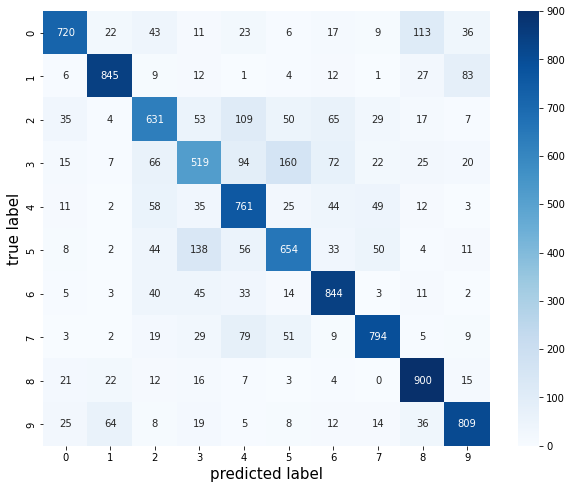

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_matrix(y_test, y_pred):
  plt.figure(figsize = (10, 8))
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
  plt.xlabel('predicted label', fontsize = 15)
  plt.ylabel('true label', fontsize = 15)
  plt.show()

plot_matrix(y_test, y_pred_argmax)

# 5. 모델 성능 향상 - ModelCheckpoint 콜백 사용

In [20]:
# 모델 준비

model = build_model()

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['acc'])

In [21]:
# 콜백준비

from tensorflow.keras import callbacks

checkpoint_path = 'temp/cifar_10.ckpt'
checkpoint = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss')

In [ ]:
# 모델학습

EPOCHS = 100
BATCH_SIZE = 256
history = model.fit(X_train, y_train_oh, epochs = EPOCHS, batch_size = BATCH_SIZE,
                    validation_data = (X_val, y_val_oh), callbacks=[checkpoint])

Epoch 1/100
137/137 [==============================] - 4s 22ms/step - loss: 2.1721 - acc: 0.1813 - val_loss: 2.0521 - val_acc: 0.2311
Epoch 2/100
137/137 [==============================] - 3s 21ms/step - loss: 1.9302 - acc: 0.2922 - val_loss: 1.9088 - val_acc: 0.2953
Epoch 3/100
137/137 [==============================] - 3s 21ms/step - loss: 1.7818 - acc: 0.3518 - val_loss: 1.7744 - val_acc: 0.3623
Epoch 4/100
137/137 [==============================] - 3s 21ms/step - loss: 1.7052 - acc: 0.3785 - val_loss: 1.7201 - val_acc: 0.3799
Epoch 5/100
137/137 [==============================] - 3s 20ms/step - loss: 1.6456 - acc: 0.4008 - val_loss: 1.6439 - val_acc: 0.4141
Epoch 6/100
137/137 [==============================] - 3s 19ms/step - loss: 1.5931 - acc: 0.4187 - val_loss: 1.5912 - val_acc: 0.4359
Epoch 7/100
137/137 [==============================] - 3s 21ms/step - loss: 1.5454 - acc: 0.4383 - val_loss: 1.5489 - val_acc: 0.4599
Epoch 8/100
137/137 [==============================] - 3s 21ms

In [ ]:
# 상태 복원

model.load_weights(checkpoint_path)

In [ ]:
#평가지표 계산

from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score

def print_score(y_test, y_pred):
  print('accuracy : %.3f' % (accuracy_score(y_test,y_pred)))
  print('precision : %.3f' % (precision_score(y_test,y_pred, average='macro')))
  print('recall_score : %.3f' % (recall_score(y_test,y_pred,average='macro')))
  print('f1_score: %.3f' % (f1_score(y_test,y_pred,average='macro')))



In [ ]:
# 예측

y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

print_score(y_test, y_pred_argmax)

313/313 [==============================] - 1s 2ms/step
accuracy : 0.760
precision : 0.758
recall_score : 0.760
f1_score: 0.757


# 6. 배치 정규화
## 과적합 문제의 해결방법중 하나로 활용

In [ ]:
# 모델구성

def build_model_bach_normalization():
  model = keras.Sequential()
  
  model.add(layers.Conv2D(32, 3, padding = 'same', input_shape = (32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Conv2D(64, 3, padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Conv2D(256, 3, padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  
  model.add(layers.Conv2D(256, 3, padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  return model

model = build_model_bach_normalization()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)      

In [ ]:
# 모델학습

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['acc'])

EPOCHS = 100
BATCH_SIZE=256

history=model.fit(X_train,y_train_oh,
                  epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=(X_val,y_val_oh))

Epoch 1/100
137/137 [==============================] - 5s 30ms/step - loss: 1.4824 - acc: 0.4732 - val_loss: 2.6856 - val_acc: 0.1027
Epoch 2/100
137/137 [==============================] - 3s 25ms/step - loss: 1.0584 - acc: 0.6275 - val_loss: 2.9830 - val_acc: 0.1781
Epoch 3/100
137/137 [==============================] - 3s 25ms/step - loss: 0.8586 - acc: 0.7048 - val_loss: 2.1325 - val_acc: 0.3600
Epoch 4/100
137/137 [==============================] - 4s 26ms/step - loss: 0.7228 - acc: 0.7586 - val_loss: 1.1999 - val_acc: 0.5836
Epoch 5/100
137/137 [==============================] - 3s 25ms/step - loss: 0.5989 - acc: 0.8075 - val_loss: 1.0209 - val_acc: 0.6419
Epoch 6/100
137/137 [==============================] - 3s 25ms/step - loss: 0.4918 - acc: 0.8518 - val_loss: 0.9377 - val_acc: 0.6732
Epoch 7/100
137/137 [==============================] - 4s 26ms/step - loss: 0.4062 - acc: 0.8827 - val_loss: 0.9467 - val_acc: 0.6759
Epoch 8/100
137/137 [==============================] - 4s 26ms

## 학습 곡선

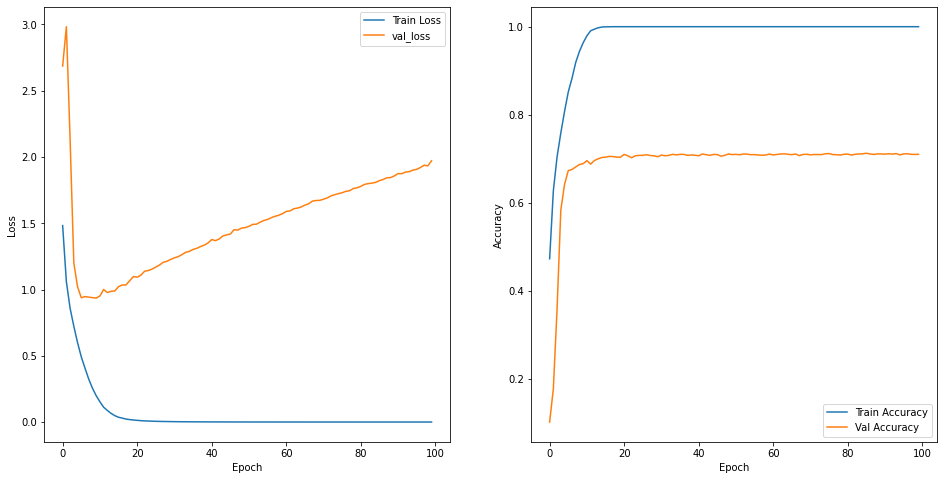

In [ ]:


plot_history(history)

## 모델평가

In [ ]:


loss, acc = model.evaluate(X_test, y_test_oh)

print('loss : ', loss)
print('acc : ', acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.0434 - acc: 0.7033
loss :  2.0433568954467773
acc :  0.7032999992370605


# 7. 데이터 증강
## 데이터 양 늘리기 - 케라스 ImageDataGenerator

In [22]:
#1. 라이브러리 임포트

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
# 데이터 셋 준비
(train_ds, val_ds, test_ds),metadata = tfds.load('tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

In [ ]:
num_classes = metadata.features['label'].num_classes
num_classes

In [ ]:
#이미지 확인

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

# 이미지 증강 방법

1.   keras 전처리 레이어 사용
2.   ImageDataGenerator 사용





#1. keras 전처리 레이어

*Resize: 사이즈 조절
*Rescaling: 표준화
*RandomFlip: 가로, 세로 반전
*RandomRotation: 회전
*RandomCrop: 이미지 잘라내기






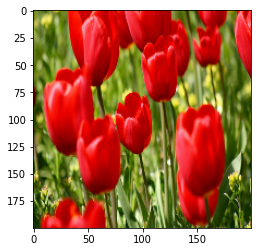

In [ ]:
# 이미지 사이즈 조절

IMG_SIZE = 200

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.imshow(result)
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
sample = tf.expand_dims(image, 0)
print(sample.shape)

(1, 333, 500, 3)


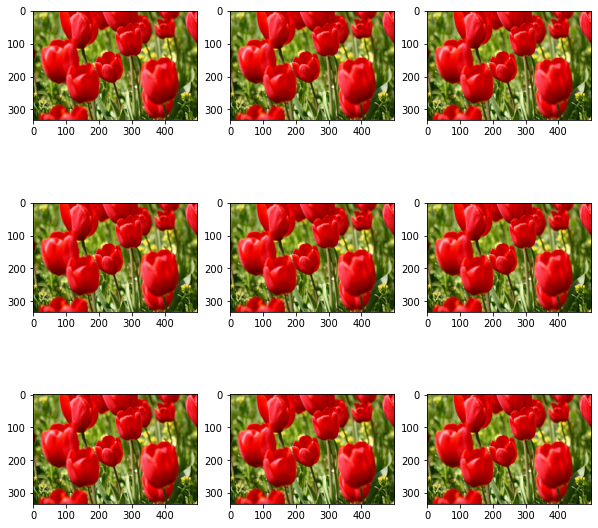

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  aug_image = data_augmentation(sample)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(aug_image[0])
  plt.axis("on")


In [ ]:
data_crop = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomCrop(height=100, width=100)
])

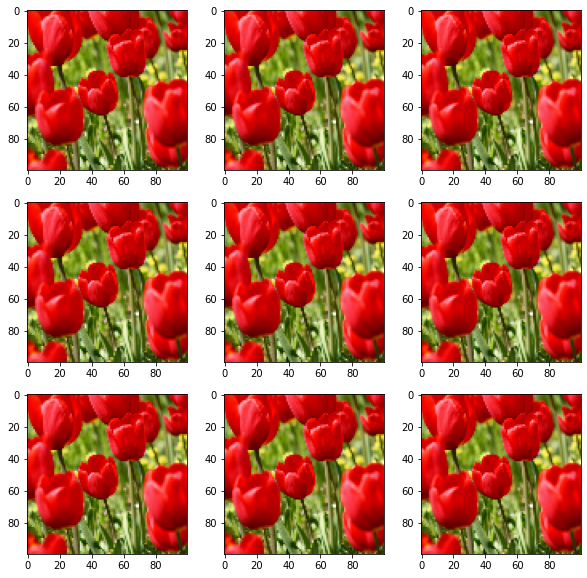

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  aug_image = data_crop(sample)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(aug_image[0])

In [ ]:
# 데이터 전처리

batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # 모든 데이터의 Resize/rescale
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch
  ds = ds.batch(batch_size)

  # training 데이터의 augmentation
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train = prepare(train_ds, shuffle=True, augment=True)
val = prepare(val_ds)
test = prepare(test_ds)

In [ ]:
# 모델 생성
def build_model():
  model = tf.keras.Sequential([
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
      ])
  return model

In [ ]:

model=build_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
histroy = model.fit(train, validation_data=val, epochs=5)

Epoch 1/5
92/92 [==============================] - 17s 156ms/step - loss: 1.6053 - accuracy: 0.2497 - val_loss: 1.8165 - val_accuracy: 0.2425
Epoch 2/5
92/92 [==============================] - 13s 135ms/step - loss: 1.6021 - accuracy: 0.2517 - val_loss: 1.7046 - val_accuracy: 0.2425
Epoch 3/5
92/92 [==============================] - 13s 135ms/step - loss: 1.6018 - accuracy: 0.2517 - val_loss: 1.6988 - val_accuracy: 0.2425
Epoch 4/5
92/92 [==============================] - 14s 146ms/step - loss: 1.6014 - accuracy: 0.2517 - val_loss: 1.6898 - val_accuracy: 0.2425
Epoch 5/5
92/92 [==============================] - 13s 135ms/step - loss: 1.6005 - accuracy: 0.2517 - val_loss: 1.6729 - val_accuracy: 0.2425


In [ ]:
loss, acc=model.evaluate(test)
loss, acc

12/12 [==============================] - 1s 52ms/step - loss: 1.7367 - accuracy: 0.1907


(1.7366622686386108, 0.19073569774627686)

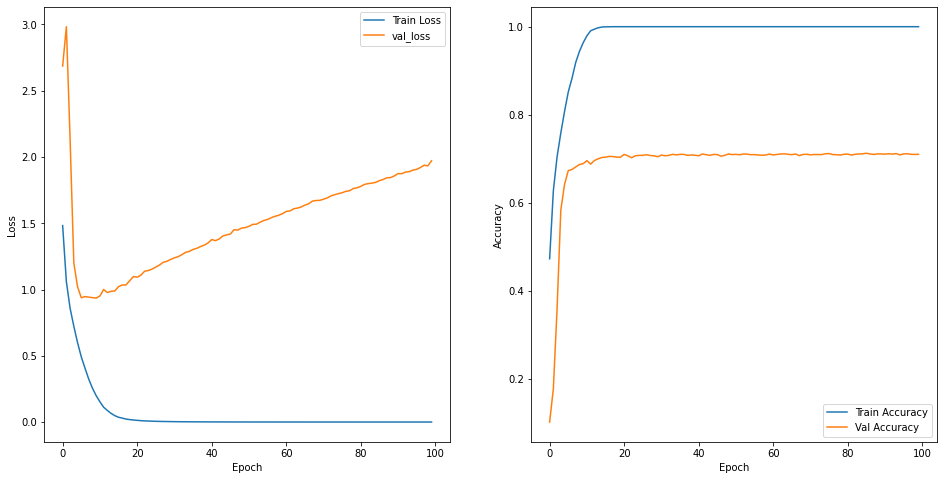

In [ ]:
plot_history(history)

# 2. ImageDataGenerator


1.   학습 도중 이미지에 임의 변형 및 정규화를 적용해 주고
2.   변형된 이미지를 배치 단위로 불러올 수 있는 Generator을 생성해 준다.



* rotation_range
*width_shift_range
*height_shift_range
*brightness_range
*zoom_range
*width_shift_range
*horizontal_flip
*vertical_flip
*preprocessing_function
*rescale





In [ ]:
import numpy as np
import pandas as pd
import os

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#이미지 다운로드
!wget https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg


--2023-01-08 09:18:08--  https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg
Resolving www.sciencenews.org (www.sciencenews.org)... 23.185.0.2, 2620:12a:8000::2
Connecting to www.sciencenews.org (www.sciencenews.org)|23.185.0.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61745 (60K) [image/jpeg]
Saving to: ‘033120_HT_covid-cat_feat-1028x579.jpg’

033120_HT_covid-cat 100%[===================>]  60.30K  --.-KB/s    in 0.007s  

2023-01-08 09:18:09 (8.12 MB/s) - ‘033120_HT_covid-cat_feat-1028x579.jpg’ saved [61745/61745]



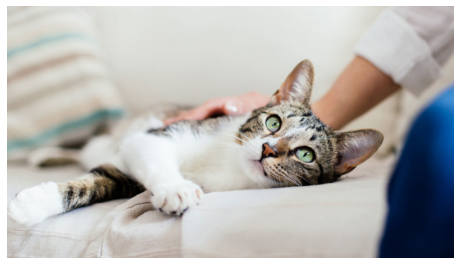

In [ ]:
image = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'),cv2.COLOR_BGR2RGB)
#content/
def show_image(image):
  plt.figure(figsize=(8,8))
  plt.imshow(image)
  plt.axis('off')

show_image(image)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(horizontal_flip = True,vertical_flip=True) #horizontal_flip = True,
image_batch = np.expand_dims(image,axis=0) #4차원으로 늘려주기

In [ ]:
# ImageDataGenerator 적용하려면 fit과 flow를 해야함.
data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

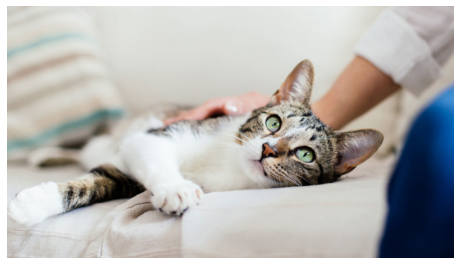

In [ ]:
#실행을 위해선 next 필요
aug_image_batch = next(data_gen_iter)
aug_image = np.squeeze(aug_image_batch)

aug_image = aug_image.astype('int')
show_image(aug_image)
